In [36]:
from transformers import AutoModel, AutoTokenizer
import torch
import clip
import json
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
import os

In [19]:
clip_device = "cuda" if torch.cuda.is_available() else "cpu"
clip_model, clip_preprocess = clip.load("ViT-B/32", device=clip_device)

bge_model_name = "BAAI/bge-large-en"
bge_tokenizer = AutoTokenizer.from_pretrained(bge_model_name)
bge_model = AutoModel.from_pretrained(bge_model_name).to(clip_device)

In [9]:
image_vector_file = "./image_vec/frame_vectors.pt"  
image_data = torch.load(image_vector_file)
image_filenames = image_data["filenames"]
image_features = image_data["features"]  

frame_json_file = "./description/5qlG1ODkRWw_frame.json" 
clip_json_file = "./description/5qlG1ODkRWw_clip.json" 

with open(frame_json_file, "r", encoding="utf-8") as f:
    frame_descriptions = json.load(f)

with open(clip_json_file, "r", encoding="utf-8") as f:
    clip_descriptions = json.load(f)

In [10]:
def encode_texts(texts, model, tokenizer, device="cpu"):
    inputs = tokenizer(texts, padding=True, truncation=True, return_tensors="pt", max_length=512)
    inputs = {key: val.to(device) for key, val in inputs.items()}
    with torch.no_grad():
        outputs = model(**inputs)
        embeddings = outputs.last_hidden_state[:, 0, :]  
        embeddings = embeddings / embeddings.norm(dim=-1, keepdim=True)  
    return embeddings

In [20]:
frame_texts = [desc["description"] for desc in frame_descriptions]
clip_texts = [desc["description"] for desc in clip_descriptions]

frame_vectors = encode_texts(frame_texts, bge_model, bge_tokenizer, clip_device)
clip_vectors = encode_texts(clip_texts, bge_model, bge_tokenizer, clip_device)

In [45]:
clip_ranges = [
    (desc["start"], desc["end"], i)
    for i, desc in enumerate(clip_descriptions)
]

In [46]:
user_query = "Reindeer looking at a fallen person in the winter forest"
bge_query_vector = encode_texts([user_query], bge_model, bge_tokenizer, clip_device)

In [47]:
def compute_similarity(query, features):
    query = query.to(features.device).to(torch.float32)
    features = features.to(torch.float32)
    return torch.matmul(features, query.T).squeeze(1).cpu().numpy()

clip_query_tokens = clip.tokenize([user_query]).to(clip_device)
with torch.no_grad():
    clip_query_vector = clip_model.encode_text(clip_query_tokens)
    clip_query_vector /= clip_query_vector.norm(dim=-1, keepdim=True)

image_similarity = compute_similarity(clip_query_vector, image_features)
frame_similarity = compute_similarity(bge_query_vector, frame_vectors)   
clip_similarity = compute_similarity(bge_query_vector, clip_vectors)   

In [48]:
weight_image = 0.3
weight_frame = 0.3
weight_clip = 0.3

final_scores = np.zeros(len(frame_descriptions))

for i, frame in enumerate(frame_descriptions):
    frame_time = frame["start"]
    clip_score = 0
    for start, end, clip_idx in clip_ranges:
        if start <= frame_time <= end:
            clip_score = clip_similarity[clip_idx]
            break

    final_scores[i] = (
        weight_image * image_similarity[i]
        + weight_frame * frame_similarity[i]
        + weight_clip * clip_score
    )


가장 유사한 프레임들:
Rank 1: 5qlG1ODkRWw_73.500.jpg (Score: 0.5721)
Frame Description: The image is a scene from an animated movie featuring two characters in a snowy forest. On the left, there is a character dressed in dark clothing with a red sash, standing next to a reindeer. The reindeer has a light gray coat and is looking towards the character. On the right, there is another character wearing a vibrant purple cloak with a blue skirt and a red headband. This character is holding a staff and appears to be engaged in conversation with the first character. The background is filled with snow-covered trees and icicles, creating a wintery atmosphere. The lighting is soft, giving the scene a magical and
Clip Description: A man is riding a reindeer in the snow. A snowman is running on the snow. A man and a woman are standing in the snow. A wolf is running in the snow. A man and a woman are sitting on a sled. A man is lying on the ground. A man and a woman are standing in the snow. A snowman is t

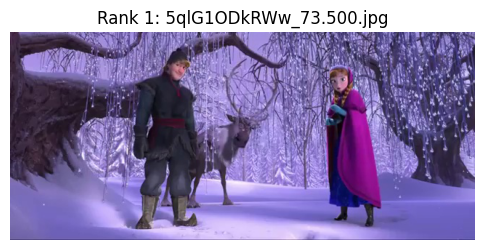

Rank 2: 5qlG1ODkRWw_36.000.jpg (Score: 0.5719)
Frame Description: The image depicts a snowy forest scene with a large, brown reindeer standing over two people lying on the ground. The reindeer appears to be wearing a harness or harness-like structure. The two people are dressed in dark clothing and are lying on the snow-covered ground. The background consists of tall, leafless trees, suggesting a winter setting. The atmosphere is cold and serene, with a misty or foggy sky adding to the wintry ambiance.
Clip Description: A man wearing a black jacket is riding on the back of a reindeer in the snow. The reindeer is running, and the man is holding on tightly. Suddenly, the reindeer stops, causing the man to fall off and land on the snow. The reindeer looks at the man with a concerned expression. Ooh, that's a rough business to be in right now.


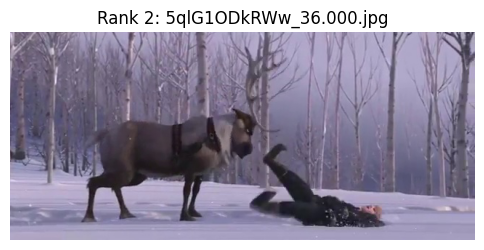

Rank 3: 5qlG1ODkRWw_37.000.jpg (Score: 0.5687)
Frame Description: The image depicts an animated reindeer standing in a snowy forest. The reindeer has large antlers and a thick, grayish-brown coat with a lighter underbelly. It appears to be wearing a harness or harness-like accessory around its neck. The forest is filled with tall, slender trees covered in snow, and the ground is blanketed in snow as well. The atmosphere is wintry and serene, with a soft, muted color palette dominated by whites and grays. The reindeer has a somewhat forlorn or contemplative expression.
Clip Description: A man wearing a black jacket is riding on the back of a reindeer in the snow. The reindeer is running, and the man is holding on tightly. Suddenly, the reindeer stops, causing the man to fall off and land on the snow. The reindeer looks at the man with a concerned expression. Ooh, that's a rough business to be in right now.


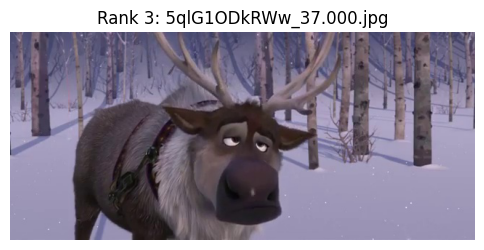

Rank 4: 5qlG1ODkRWw_54.500.jpg (Score: 0.5648)
Frame Description: The image depicts a winter scene with two characters in a snowy forest. The character on the left is sitting on the ground, wearing a vibrant blue dress with a pink cape and a white fur hat. They are holding a large, fluffy white sack, possibly containing gifts or supplies. The character on the right is standing, dressed in a dark coat and hat, and appears to be interacting with a snowman in front of them. The snowman is made of snow and has a carrot nose and coal eyes. The background is filled with snow-covered trees and icicles hanging from branches, creating a magical, wintry atmosphere. The overall color
Clip Description: A man wearing a black coat is throwing snowballs at the woman. A woman wearing a purple coat is throwing snowballs at the man. A snowman is standing in front of the man and the woman. The woman is riding on a sled pulled by a reindeer. The man is riding on a sled pulled by a reindeer. I don't want i

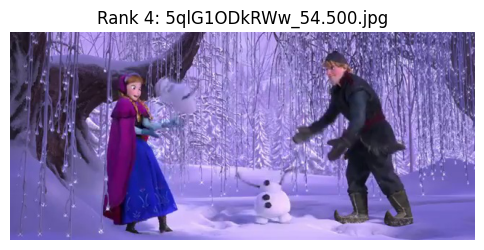

Rank 5: 5qlG1ODkRWw_59.500.jpg (Score: 0.5631)
Frame Description: The image depicts an animated scene featuring a reindeer pulling a sled through a snowy landscape. The reindeer is large and has prominent antlers. On the sled, there are two characters: one appears to be an adult wearing a dark outfit, and the other is a child in a red outfit. The background is dark, suggesting it might be nighttime, with snow-covered ground and rocky cliffs visible on the sides. The scene has a cold, wintry atmosphere.
Clip Description: A man wearing a black coat is throwing snowballs at the woman. A woman wearing a purple coat is throwing snowballs at the man. A snowman is standing in front of the man and the woman. The woman is riding on a sled pulled by a reindeer. The man is riding on a sled pulled by a reindeer. I don't want it! No! Alright, we got off to a bad start. I know how to stop this winter. Yah! Hang on!


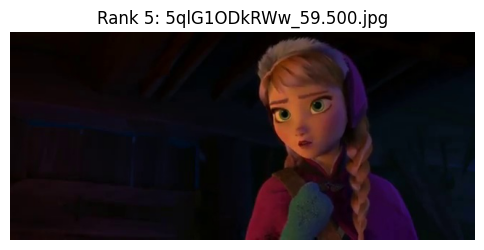

In [49]:
top_n = 5
top_indices = final_scores.argsort()[-top_n:][::-1]

base_path = "./image_vec/frames"  

print("\n가장 유사한 프레임들:")
for rank, idx in enumerate(top_indices, 1):
    frame_info = frame_descriptions[idx]
    frame_time = frame_info["start"]
    video_id = frame_info["video_id"]

    clip_description = next(
        (desc["description"] for desc in clip_descriptions
         if desc["start"] <= frame_time <= desc["end"]),
        "No clip description found."
    )

    image_filename = f"{video_id}_{frame_time:.3f}.jpg"
    image_path = os.path.join(base_path, image_filename)

    print(f"Rank {rank}: {image_filename} (Score: {final_scores[idx]:.4f})")
    print(f"Frame Description: {frame_info['description']}")
    print(f"Clip Description: {clip_description}")

    try:
        image = Image.open(image_path)
        plt.figure(figsize=(6, 6))
        plt.imshow(image)
        plt.title(f"Rank {rank}: {image_filename}")
        plt.axis('off')
        plt.show()
    except FileNotFoundError:
        print(f"이미지 파일을 찾을 수 없습니다: {image_path}")